In [1]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd
import pprint

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# To suppress warnings
import warnings

warnings.filterwarnings("ignore")
main_data = pd.read_csv('BankChurners.csv')

default_color_palette  = ["#03A9F4","#7C4DFF", "#FF5252", "#D50000", "#FF6F00", "#0288D1", "#7C4DFF"] 
stats_colors           = {'Mean':'#D50000', 'Mode':'#FF3D00', 'Median':'#2962FF'} # Set standard colors for mean, mode and median to use accross entire notebook.
gender_color_palette   = {"Female":"#E91E63", "Male":"#42A5F5"} # Gender based colors.

In [2]:
'''
Input:
Pandas DataFrame

Output:
Displays DataFrame structure 
(columns, nulls and non nulls counts and percentage highlighing columns with most number of nulls)

Retunrs:
N/A
'''
def info(dataFrame):
    print(f"{dataFrame.shape[0]} Rows x {dataFrame.shape[1]} Columns")
    nulls_series      = dataFrame.isna().sum()         # Get a series counting number of empty values for each column
    nonnulls_series   = dataFrame.notnull().sum()      # Get a series counting number of non empty valuesfor each column 
    nulls_percentage  = ((nulls_series * 100)/(nulls_series + nonnulls_series)).astype(float)
    column_datatypes  = dataFrame.dtypes               # Get a series containing data types for each column 
    
    series_arr    = [nulls_series, nonnulls_series, nulls_percentage, column_datatypes]
    col_names_arr = ["Nulls", "Non-Nulls","Nulls %", "Type"]
    
    nulls_count_df = pd.concat(
        objs = series_arr,
        axis = 1,
        keys = col_names_arr, 
        sort = True)
    
    cm = sns.light_palette("red", as_cmap=True)
    display(nulls_count_df.style.background_gradient(cmap=cm, subset=pd.IndexSlice[:, ['Nulls %']]).format(formatter={('Nulls %'): "{:.2f}%"})) 
    

'''
Input:
Target type and a list of feature names.

Output:
Convert all features provided in 'column_names' to Target type provided in 'toType'

Returns:
modifies main original data frame and returns nothing.
'''
def ConvertColTo(toType, column_names=np.nan, df = np.nan):
    for col_name in column_names:
        df[col_name] = df[col_name].astype(toType)


'''
Input:
N/A

Output:
Go through each categorial column and print unique values for that column.

Retunrs:
N/A
'''
def CountUniqueValues(col_names):
    for col_name in col_names:
        print(f"======================='{col_name}'==================")
        for unique_col_value in  main_data[col_name].unique().tolist():
            total_count = main_data[col_name].count()
            unique_values_count = main_data[main_data[col_name] == unique_col_value][col_name].count()
            percentage = str(round((unique_values_count/total_count) * 100, 2))
            print(f"{unique_col_value} \t: {unique_values_count} ({percentage}%)")
        print(f"=========================================================\n")

'''
Description:
Given the model the test data y values, displays the confusion matrix for that model.

Input:
model    - The learning model.
y_actual - Y values from test data.
labels   - the labels

Returns:
N/A
'''
def DisplayConfusionMatrix(model, y_actual, labels=[1,0]):
    y_predict             = model.predict(x_test)
    confusion_matrix      = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    
    confusion_matix_df = pd.DataFrame(
        data    = confusion_matrix,
        index   = [i for i in ["Actual No", "Actual Yes"]],
        columns = [i for i in ["Predicted - No", "Predicted - Yes"]])
    
    group_counts     = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    group_percetages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percetages)]
    labels = np.array(labels).reshape(2, 2)
    plt.figure(figsize= (10,7))
    sns.heatmap(confusion_matix_df, annot=labels,fmt='')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

'''
Description:
Given the model, computes models perfomance on test and training data.
Perf metrics displayed are: Accuracy, Recall, F1 Score, and precision.

Input:
model - The learning model.

Returns:
A dictionary containing models perfomace.
'''
def GetMetricsScore(model):
    
    pred_train      = model.predict(x_train)
    pred_test       = model.predict(x_test)
    
    train_accuracy  = model.score(x_train, y_train)
    test_accuracy   = model.score(x_test, y_test)
    
    train_recall    = metrics.recall_score(y_train, pred_train)
    test_recall     = metrics.recall_score(y_test, pred_test)
    
    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision  = metrics.precision_score(y_test, pred_test)

    f1_score_train  = 2 * ((train_precision * train_recall)/(train_precision + train_recall))
    f1_score_test   = 2 * ((test_precision * test_recall)/(test_precision + test_recall))
    
    return {
        'Accuracy_Test'   : test_accuracy,
        'Accuracy_Train'  : train_accuracy,
        'Recall_Test'     : test_recall,
        'Recall_Train'    : train_recall,
        'Precision_Test'  : test_precision,
        'Precision_Train' : train_precision,
        'F1_Score_Train'  : f1_score_train,
        'F1_Score_Test'   : f1_score_test
    }
        
'''
Description:
Given the model, displays the importance score.

Input:
model - The learning model.

Returns:
N/A
'''
def DisplayImportanceScores(model):
    gini_importances = pd.DataFrame(
        data    = model.feature_importances_, 
        columns = ["Imp"],
        index   = x_train.columns).sort_values(by = "Imp")
    
    print(gini_importances)

'''
Description:
Given the model, displays the importance chart.

Input:
model    - The learning model.

Returns:
N/A
'''
def DisplayImportanceChart(model):
    importances = model.feature_importances_
    indices     = np.argsort(importances)

    plt.figure(figsize=(12, 12))
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [list(X.columns)[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

'''
Description:
Given the decision tree model, displays the decision tree of that model.

Input:
model - The learning model.
size  - Size of the plot

Returns:
N/A
'''
def PlotDecisionTree(model, size= [20, 30]):
    plt.figure(figsize=(size[0],size[1]))
    tree.plot_tree(model, feature_names=feature_names, filled=True, fontsize=9, node_ids=True, class_names=True)
    plt.show()
 
'''
Description:
Given a model, displays the coefient values of that model

Input:
model - The learning model.

Returns:
N/A
'''
def DisplayCoeficients(model):
    coefs = pd.DataFrame(
        np.append(model.coef_, model.intercept_),
        index=x_train.columns.tolist() + ["Intercept"],
        columns=["Coefficients"],
    )

    coefs.sort_values('Coefficients')

In [3]:
main_data.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,810347208,Existing Customer,51,M,4,NaN,Married,$120K +,Gold,46,...,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,818906208,Existing Customer,32,M,0,High School,NaN,$60K - $80K,Silver,27,...,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


In [4]:
TARGET_COLUMN = 'Attrition_Flag'

In [5]:
info(main_data)

10127 Rows x 21 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,object
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
CLIENTNUM,0,10127,0.00%,int64
Card_Category,0,10127,0.00%,object
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,1519,8608,15.00%,object


In [6]:
main_data.drop("CLIENTNUM", axis=1, inplace=True)

In [7]:
catgry_col_names = main_data.select_dtypes(include=['object']).columns.tolist()
catgry_col_names.remove(TARGET_COLUMN)

In [8]:
ConvertColTo('category', catgry_col_names, main_data)

In [9]:
catgry_col_names = main_data.select_dtypes(include=['category']).columns.tolist()
CountUniqueValues(catgry_col_names)

======================='Gender'==================
M 	: 4769 (47.09%)
F 	: 5358 (52.91%)

======================='Education_Level'==================
High School 	: 2013 (23.39%)
Graduate 	: 3128 (36.34%)
Uneducated 	: 1487 (17.27%)
nan 	: 0 (0.0%)
College 	: 1013 (11.77%)
Post-Graduate 	: 516 (5.99%)
Doctorate 	: 451 (5.24%)

======================='Marital_Status'==================
Married 	: 4687 (49.98%)
Single 	: 3943 (42.05%)
nan 	: 0 (0.0%)
Divorced 	: 748 (7.98%)

======================='Income_Category'==================
$60K - $80K 	: 1402 (13.84%)
Less than $40K 	: 3561 (35.16%)
$80K - $120K 	: 1535 (15.16%)
$40K - $60K 	: 1790 (17.68%)
$120K + 	: 727 (7.18%)
abc 	: 1112 (10.98%)

======================='Card_Category'==================
Blue 	: 9436 (93.18%)
Gold 	: 116 (1.15%)
Silver 	: 555 (5.48%)
Platinum 	: 20 (0.2%)



In [10]:
main_data['Education_Level'].fillna(main_data['Education_Level'].value_counts().idxmax(), inplace=True)
main_data['Marital_Status'].fillna(main_data['Marital_Status'].value_counts().idxmax(), inplace=True)

In [11]:
info(main_data)

10127 Rows x 20 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,object
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
Card_Category,0,10127,0.00%,category
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,0,10127,0.00%,category
Gender,0,10127,0.00%,category


In [12]:
CountUniqueValues(catgry_col_names)

======================='Gender'==================
M 	: 4769 (47.09%)
F 	: 5358 (52.91%)

======================='Education_Level'==================
High School 	: 2013 (19.88%)
Graduate 	: 4647 (45.89%)
Uneducated 	: 1487 (14.68%)
College 	: 1013 (10.0%)
Post-Graduate 	: 516 (5.1%)
Doctorate 	: 451 (4.45%)

======================='Marital_Status'==================
Married 	: 5436 (53.68%)
Single 	: 3943 (38.94%)
Divorced 	: 748 (7.39%)

======================='Income_Category'==================
$60K - $80K 	: 1402 (13.84%)
Less than $40K 	: 3561 (35.16%)
$80K - $120K 	: 1535 (15.16%)
$40K - $60K 	: 1790 (17.68%)
$120K + 	: 727 (7.18%)
abc 	: 1112 (10.98%)

======================='Card_Category'==================
Blue 	: 9436 (93.18%)
Gold 	: 116 (1.15%)
Silver 	: 555 (5.48%)
Platinum 	: 20 (0.2%)



In [13]:
replace_struct = {
    "Card_Category"       : {"Blue": 1, "Silver": 2, "good": 3, "Gold": 4, "Platinum": 5},
    "Income_Category"     : {"abc": -1, "Less than $40K": 1, "$40K - $60K": 2, "$60K - $80K": 3, "$80K - $120K": 4, "$120K +": 5},
    "Education_Level"     : {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4, "Post-Graduate":5, "Doctorate": 6},
    "Attrition_Flag"      : {"Existing Customer": 0, "Attrited Customer": 1},
}

main_data = main_data.replace(replace_struct)
main_data.head(10)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,2,Married,3,1,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,4,Single,1,1,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,4,Married,4,1,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,2,Married,1,1,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,1,Married,3,1,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,0,44,M,2,4,Married,2,1,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,0,51,M,4,4,Married,5,4,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,0,32,M,0,2,Married,3,2,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,0,37,M,3,1,Single,3,1,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,0,48,M,2,4,Single,4,1,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


In [14]:
oneHotCols = ["Gender", "Marital_Status"]
main_data = pd.get_dummies(main_data, columns=oneHotCols)
info(main_data)

10127 Rows x 23 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,int64
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
Card_Category,0,10127,0.00%,int64
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,0,10127,0.00%,int64
Gender_F,0,10127,0.00%,uint8


In [15]:
main_data[TARGET] = pd.to_numeric(main_data[TARGET_COLUMN], downcast="integer")

In [16]:
info(main_data)

10127 Rows x 23 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,int8
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
Card_Category,0,10127,0.00%,int64
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,0,10127,0.00%,int64
Gender_F,0,10127,0.00%,uint8


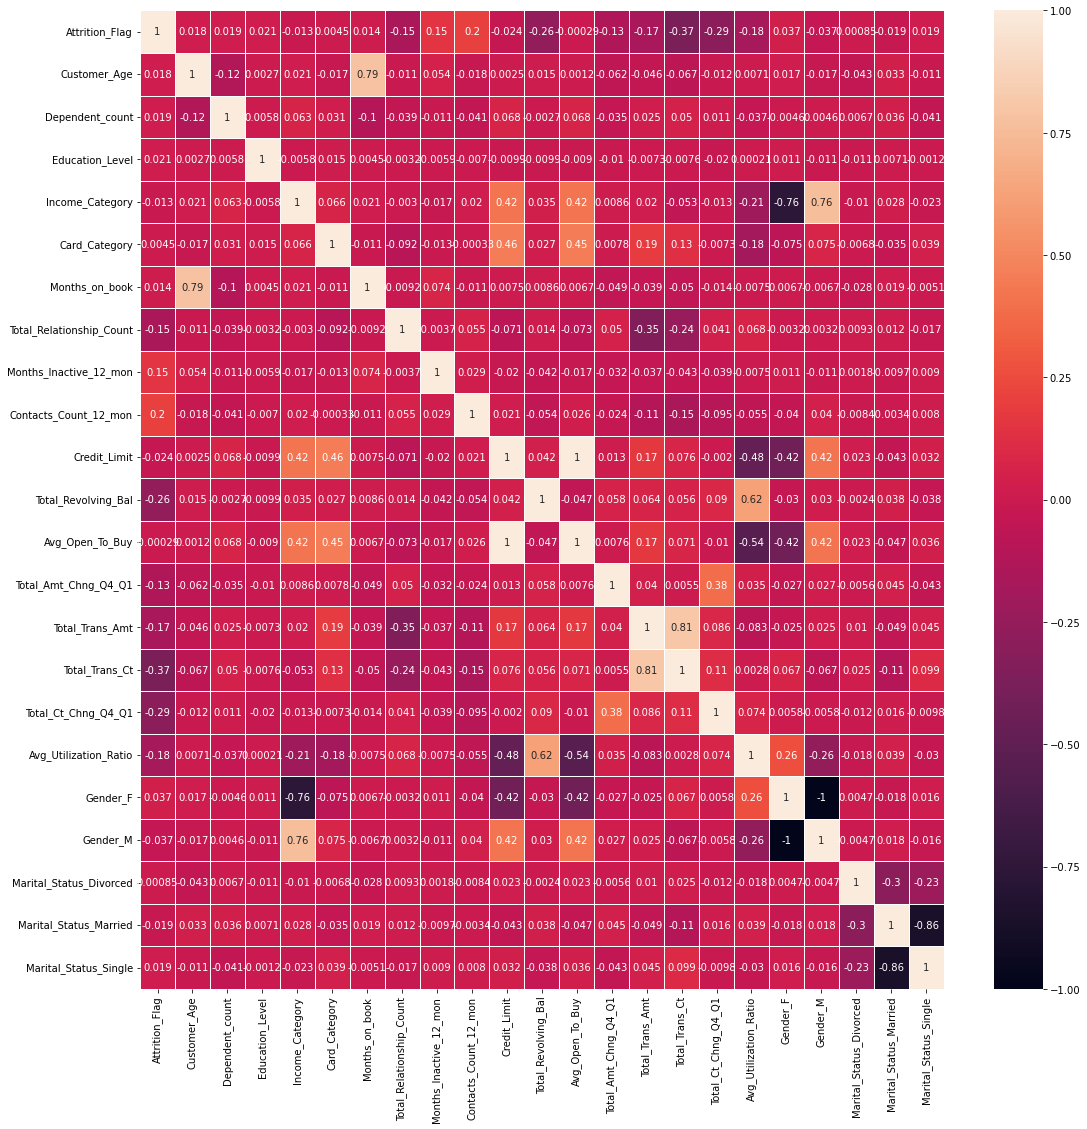

In [17]:
fig, ax = plt.subplots(figsize=(18,18)) 
sns.heatmap(data=main_data.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

In [1]:
'''
Input:
Axis, column name/x-axis, hue name

Output:
Displays a count plot.

Retunrs:
N/A
''' 
def HistBoxplot(box_chart_ax, hist_chart_ax, x_axis):
    sns.boxplot(
        data=main_data,
        x=main_data[x_axis],
        showmeans=True,
        ax=box_chart_ax)
    
    sns.histplot(
        data=main_data,
        x=main_data[x_axis],
        kde=True,
        ax=hist_chart_ax)
    
    hist_chart_ax.axvline(main_data[x_axis].mean(),                 # Get the mean of the values in the given column and draw a vertical line that cuts the chart on the mean value 
               color=stats_colors['Mean'],                                  # Use on of the colors predefined on this notebook
               label='Mean',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(main_data[x_axis].median(),               # Plot the median line on the chart.
               color=stats_colors['Median'],                                # Use on of the colors predefined on this notebook
               label='Median',                                              # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(main_data[x_axis].mode()[0],              # Plot the mode line on the chart.
               color=stats_colors['Mode'],                                  # Use on of the colors predefined on this notebook 
               label='Mode',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.legend(loc='upper right')

'''
Input:
N/A

Output:
Displays a a grid of [Boxplot x Distribution chart] for discrete features.

Returns:
N/A
''' 
def PlotHistBoxGrid():
    col_names = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()
    print(col_names)

    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, (box, hist) = plt.subplots(
            nrows=2,                                                                # Number of rows of the grid
            ncols=3,                                                                # Number of columns of the grid.
            figsize=(15,4),
            gridspec_kw={"height_ratios" : (0.25,0.5)},
            constrained_layout=True)

        for index in range(0, 3):
            if col_index < int(len(col_names)):
                HistBoxplot(box.flat[index], hist.flat[index], col_names[col_index])
            col_index += 1
            
'''
Input:
Column name

Output:
A series containing interquatile range values

Retunrs:
A dictionary containing quatile range values
''' 
def Get_IQR(data):
    quartiles = np.quantile(data, [.25, .75])
    iqr = (quartiles[1] - quartiles[0])
    print(f'Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, IQR = {iqr}')
    return {
        "Q1": quartiles[0],
        "Q3": quartiles[1],
        "IQR": iqr
    }


def ReplaceOutliers(col_names, df):
    for column in col_names:
        iqr_scale = 1

['Customer_Age', 'Dependent_count', 'Education_Level', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


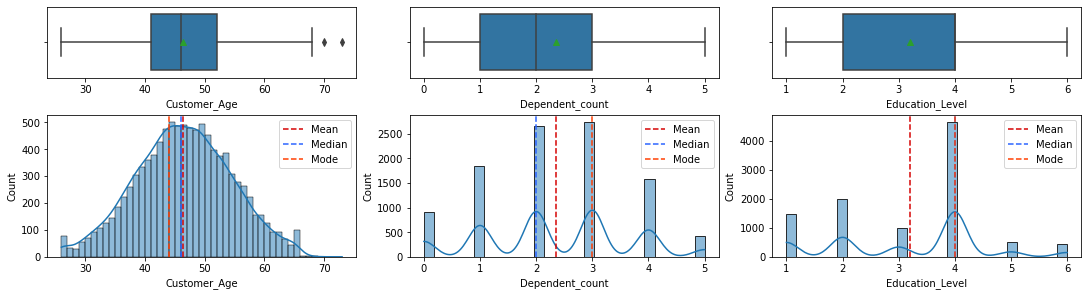

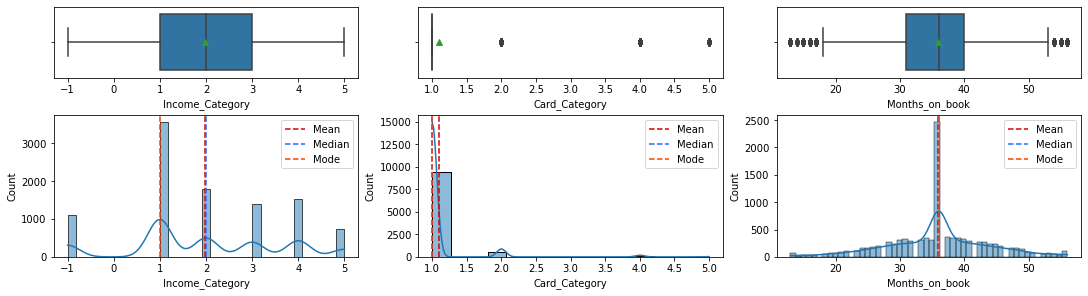

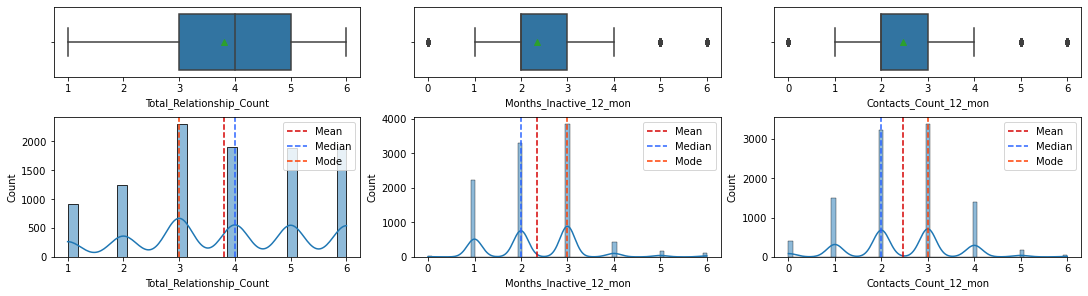

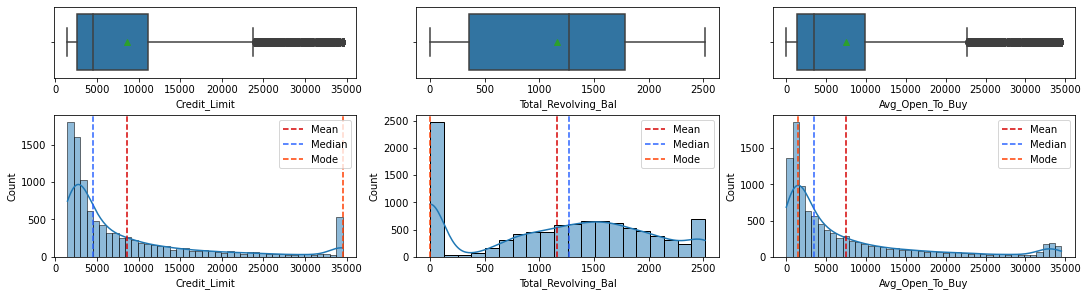

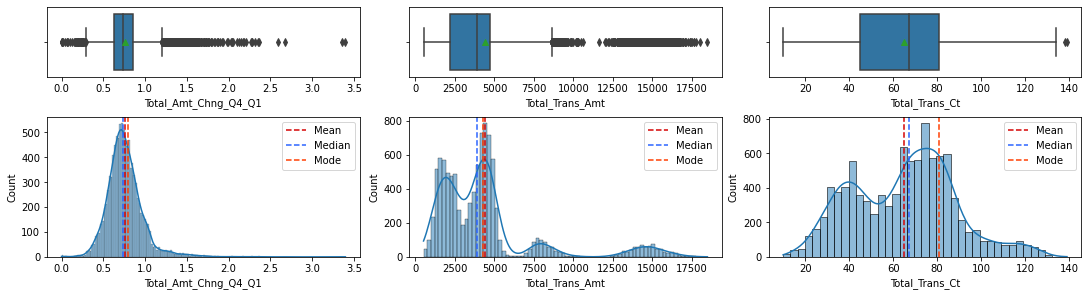

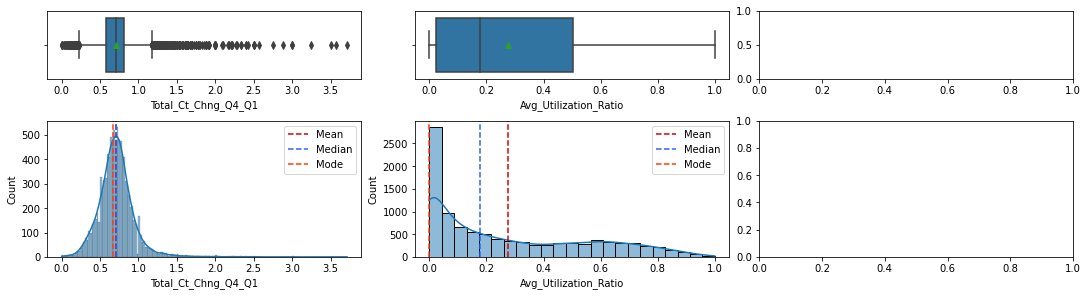

In [19]:
PlotHistBoxGrid()

In [20]:
previous_corr = [main_data.corr()[[TARGET]]]
col_names = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()

main_data_copy = main_data.copy()
for col_name in col_names:
    print(f"==========================={col_name}====================")
    main_data[col_name] = np.where(
        main_data_copy[col_name] < Get_IQR(col_name)[0],
        main_data_copy[col_name].mode(),
        main_data_copy[col_name])
    print(f"=========================================================")

previous_corr.append(main_data_copy.corr()[[TARGET]])

===========================Customer_Age====================
Q1 = 39.0, Q3 = 52.0, 4*IQR = 52.0
<PandasArray>
[]
Length: 0, dtype: int64
===========================Dependent_count====================
Q1 = 1.0, Q3 = 3.0, 4*IQR = 8.0
<PandasArray>
[]
Length: 0, dtype: int64
===========================Education_Level====================
Q1 = 2.0, Q3 = 4.0, 4*IQR = 8.0
<PandasArray>
[]
Length: 0, dtype: int64
===========================Income_Category====================
Q1 = 1.0, Q3 = 3.0, 4*IQR = 8.0
<PandasArray>
[]
Length: 0, dtype: int64
===========================Card_Category====================
Q1 = 1.0, Q3 = 1.0, 4*IQR = 0.0
<PandasArray>
[4, 2, 4, 2, 2, 2, 2, 2, 2, 2,
 ...
 2, 4, 2, 2, 2, 2, 2, 2, 4, 2]
Length: 691, dtype: int64
===========================Months_on_book====================
Q1 = 30.0, Q3 = 40.0, 4*IQR = 40.0
<PandasArray>
[]
Length: 0, dtype: int64
===========================Total_Relationship_Count====================
Q1 = 2.0, Q3 = 5.0, 4*IQR = 12.0
<PandasArray>

ValueError: operands could not be broadcast together with shapes (10127,) (2,) (10127,) 

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data=pd.concat(previous_corr, axis=1), annot=True, linewidths=.5, ax=ax)
plt.show()